In [1]:
import pandas as pd
import numpy as np
import lifelines # for survival analysis
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
df = pd.read_csv('beetles.csv', parse_dates=['date treated', 'date dead'])
df

,ID,Group,Sex,date treated,date dead,OrNV detected,Notes
0,1,A,F,2023-03-06,2023-04-10,NaN,NaN
1,2,A,M,2023-03-06,2023-03-27,NaN,NaN
2,3,A,F,2023-03-06,NaT,NaN,NaN
3,4,A,M,2023-03-06,2023-03-26,NaN,NaN
4,5,A,F,2023-03-06,NaT,NaN,NaN
...,...,...,...,...,...,...,...
110,111,D,M,2023-03-06,NaT,NaN,NaN
111,112,D,M,2023-03-06,2023-03-27,NaN,NaN
112,113,D,F,2023-03-06,2023-03-26,NaN,NaN
113,114,D,M,2023-03-06,NaT,NaN,NaN


In [3]:
df['date dead'].max()

Timestamp('2023-04-11 00:00:00')

In [4]:
df['days_post_treatment'] = (df['date dead'] - pd.to_datetime(df['date treated'])).dt.days
df['dead'] = df['days_post_treatment'].notna()
df['days_post_treatment'] = df.days_post_treatment.fillna(df.days_post_treatment.max())
df

,ID,Group,Sex,date treated,date dead,OrNV detected,Notes,days_post_treatment,dead
0,1,A,F,2023-03-06,2023-04-10,NaN,NaN,35.0,True
1,2,A,M,2023-03-06,2023-03-27,NaN,NaN,21.0,True
2,3,A,F,2023-03-06,NaT,NaN,NaN,36.0,False
3,4,A,M,2023-03-06,2023-03-26,NaN,NaN,20.0,True
4,5,A,F,2023-03-06,NaT,NaN,NaN,36.0,False
...,...,...,...,...,...,...,...,...,...
110,111,D,M,2023-03-06,NaT,NaN,NaN,36.0,False
111,112,D,M,2023-03-06,2023-03-27,NaN,NaN,21.0,True
112,113,D,F,2023-03-06,2023-03-26,NaN,NaN,20.0,True
113,114,D,M,2023-03-06,NaT,NaN,NaN,36.0,False


In [5]:
df = df[df.days_post_treatment > 0]
# df = df[df.Sex == 'M']
treated = (df.Group == 'C') | (df.Group == 'D')
untreated = (df.Group == 'A') | (df.Group == 'B')

stats = lifelines.statistics.logrank_test(
    durations_A = df[treated]['days_post_treatment'],
    durations_B = df[untreated]['days_post_treatment'],
    event_observed_A = df[treated]['dead'],
    event_observed_B = df[untreated]['dead'])
print(stats)

if stats.p_value < 0.05:
    stats_result = f'Difference between curves is significant (logrank test; p = {stats.p_value:.3f})'
else:
    stats_result = f'Difference between curves is not significant\n(logrank test; p = {stats.p_value:.3f})'
print(stats_result)

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.40 0.53      0.93
Difference between curves is not significant
(logrank test; p = 0.526)


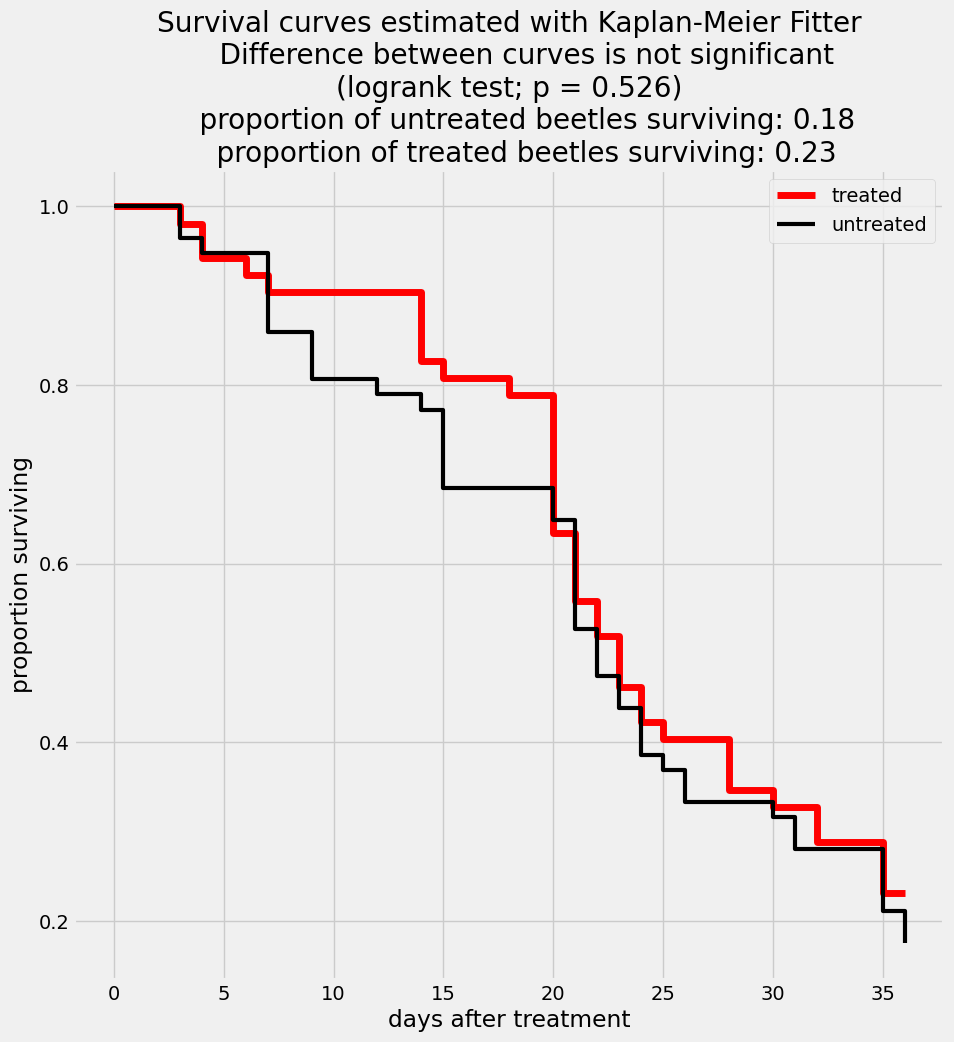

In [6]:
ax = plt.subplot()
kmf = lifelines.KaplanMeierFitter()

kmf.fit(durations=df[treated]['days_post_treatment'],
        event_observed=df[treated]['dead'], 
        label='treated')
kmf.plot(figsize=(8,8), ax=ax, ci_show=False, color='red', linewidth=5)

kmf.fit(durations=df[untreated]['days_post_treatment'], 
        event_observed=df[untreated]['dead'], 
        label='untreated')
kmf.plot(figsize=(10,10), ax=ax, ci_show=False, color='black', linewidth=3)

title = f'''Survival curves estimated with Kaplan-Meier Fitter
    {stats_result}
    proportion of untreated beetles surviving: {1 - sum(untreated & df.dead)/sum(untreated):.2f}
    proportion of treated beetles surviving: {1 - sum(treated & df.dead)/sum(treated):.2f}'''

plt.title(title)
plt.xlabel('days after treatment')
plt.ylabel('proportion surviving')
plt.savefig('results.png', bbox_inches='tight')
plt.show();